In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import Adam
import yfinance as yf

#Configure Matlab plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

In [215]:
ticker = yf.Ticker('RIO')
aapl_df = ticker.history(period="10y")
aapl_closes=aapl_df[["Close"]]

# CNN Time serries Prediction

The task of this Multi-Layer Perceptrons Model is to predict the next value in a time serries based on the previous 16 values. The precedure for trainin this model is taking the first 80% of the time serries, and splitting into 16 long slices of the data for each index, and then taking the 17th value in that window and storing it for validation. The 16 value slice would be fed into the neural network, and would return 1 value for the prediction. It would then use MSE to calculate the loss using the 17th value which had been previously stored. Once loss was acceptably low, the model would then be used to predict values in the testing set, and the predictions are compared to the real values in the Graphs shown below.

Data

In [216]:
#opens the csv file as a pandas dataframe
df = pd.read_csv("RSXFSN.csv")
# keep real GDP only
keep_columns = ['RSXFSN']
#gets rid of the date column
df = df[keep_columns]
# rescales the data to be a fraction, because the values are large
df = df/10000
df=aapl_closes
#df = df/1000

Data Processing

In [217]:
# split train & test data
#defines the number that is 80% of the length of the dataset, which will be the length of the training set
n_train = int(len(df) * 0.8)
#defines the number that is 20% of the length of the dataset, which will be the length of the testing set
n_test = len(df) - n_train
#splits the dataset into 20% and 80% pieces, and stores them in train and test respectively (training set and testing set)
train, test = df.iloc[0:n_train], df.iloc[n_train:len(df)]
#prints the length of the training set and testing set
print(len(train), len(test))



2015 504


In [218]:
#A function for returning a time serries slice, which takes dataset x and int n_steps which defaults to 1
def get_timeseries(x, n_steps=1):
    #defines empty lists
    x_ts, y_ts = [], []
    #interates over the indicies of x, until it is n_steps away (avoids out of bounds error)
    for ii in range(len(x) - n_steps):
        #stores values from the current index, to BEFORE the index that is n_steps away
        v = x.iloc[ii:(ii + n_steps)].values
        #apends to the time serries list
        x_ts.append(v)
        #stores the value n_steps away from the current index, for validation purposes
        w = x.iloc[ii + n_steps].values
        #appends this to the ground truth list for validation later on
        y_ts.append(w)
    return np.array(x_ts), np.array(y_ts)

In [219]:
#defines the size of the slice of the time serries
n_steps = 16
#the number of features we're using
n_features = 1

# convert to a time series dimension: [samples, n_steps, n_features]

#gets an array of time serries slices, and the next value following the slice for the training set
x_train, y_train = get_timeseries(train, n_steps)
#gets an array of time serries slices, and the next value following the slice for the test set
x_test, y_test = get_timeseries(test,n_steps)

#prints the shape of the two arays returned by calling the function
#the second aray is one dimensional, as is is only storing a value in each index, instead of a list of values
print(x_train.shape, y_train.shape)

(1999, 16, 1) (1999, 1)


Model

In [220]:
# define model
#creates a sequential model (simple neural network structure)
model = Sequential()
#adds 50 fully conected nodes that take input dimensions equal to the number of n_steps (taking x_train or x_test as input), with a relu as the activation
model.add(Conv1D(filters=128,kernel_size=3,activation='relu', input_shape=(n_steps,n_features)))
#model.add(MaxPooling1D(2))
#model.add(Dropout(0.001))
model.add(Flatten())
#adds a layer with one neuron (the head), which predicts only one number (the next value in the time serries)
#adds a layer with one neuron (the head), which predicts only one number (the next value in the time serries)
model.add(Dense(1))
#compiles the model with mean squared error as the loss function, uding Adam as the optimizer
model.compile(loss='mean_squared_error', optimizer=Adam(0.001))

Training

In [221]:
# fit model
#we store the output in history, so we can analyze the results at each stage
#we give it the x_train to train off of, and y_train to validate
#we define 500 epochs, with a batch size of 32, and configure it to print the loss
history = model.fit(x_train, y_train,epochs=2000,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/2000
57/57 [==============================] - 1s 3ms/step - loss: 48.7682 - val_loss: 10.4991
Epoch 2/2000
57/57 [==============================] - 0s 1ms/step - loss: 2.0966 - val_loss: 6.8108
Epoch 3/2000
57/57 [==============================] - 0s 1ms/step - loss: 1.8964 - val_loss: 6.9565
Epoch 4/2000
57/57 [==============================] - 0s 1ms/step - loss: 1.9193 - val_loss: 6.5559
Epoch 5/2000
57/57 [==============================] - 0s 1ms/step - loss: 1.9782 - val_loss: 6.2741
Epoch 6/2000
57/57 [==============================] - 0s 2ms/step - loss: 2.0088 - val_loss: 6.3652
Epoch 7/2000
57/57 [==============================] - 0s 1ms/step - loss: 1.9776 - val_loss: 6.4355
Epoch 8/2000
57/57 [==============================] - 0s 1ms/step - loss: 1.9268 - val_loss: 6.4041
Epoch 9/2000
57/57 [==============================] - 0s 1ms/step - loss: 1.8846 - val_loss: 6.3757
Epoch 10/2000
57/57 [==============================] - 0s 1ms/step - loss: 1.8535 - val_loss: 6.35

loss starts fairly high (at aprox 5.8 and 7.8), and drops fairly low by the end of the training (at aprox 0.51 and 0.41)

Evaluation

In [222]:
#uses the model to predict values based on x_test, which stores the time serries slices
y_pred = model.predict(x_test)

16/16 [==============================] - 0s 670us/step


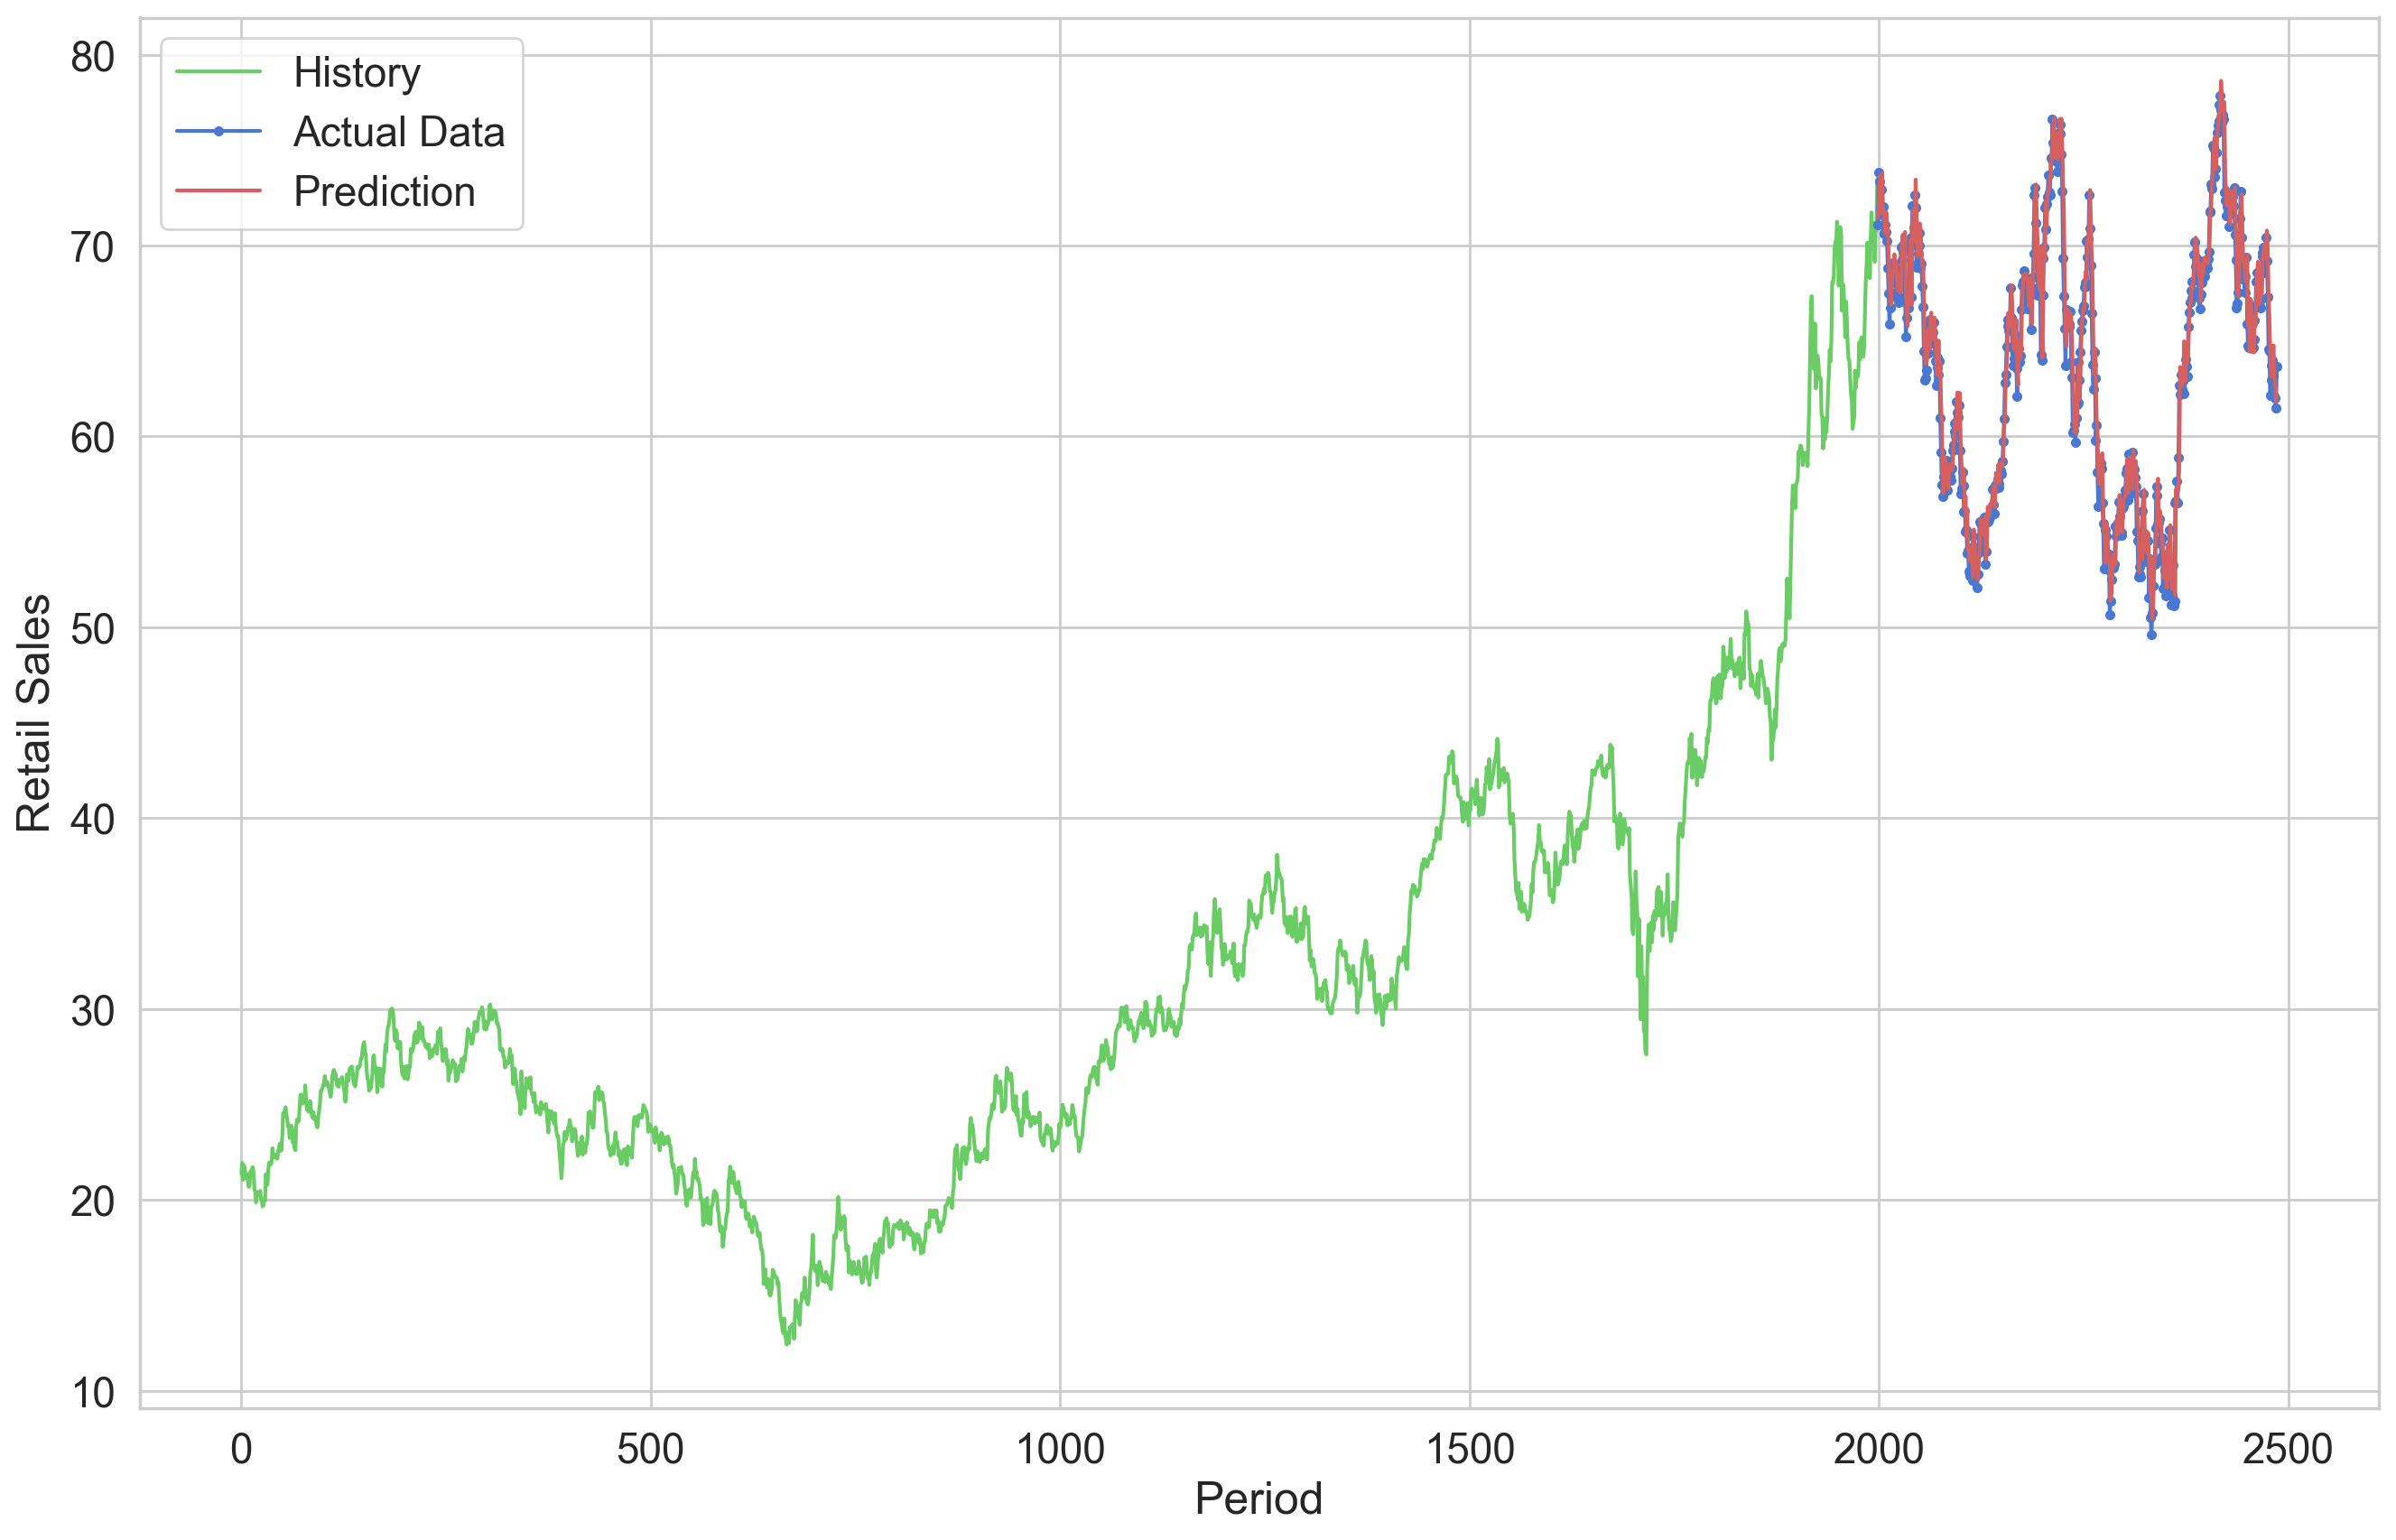

In [223]:
#plots the y_training data
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
#plots the y_test data, the true values for the time serries
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual Data")
#plots the values we predicted for the time serries, y_pred
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show();

488   488


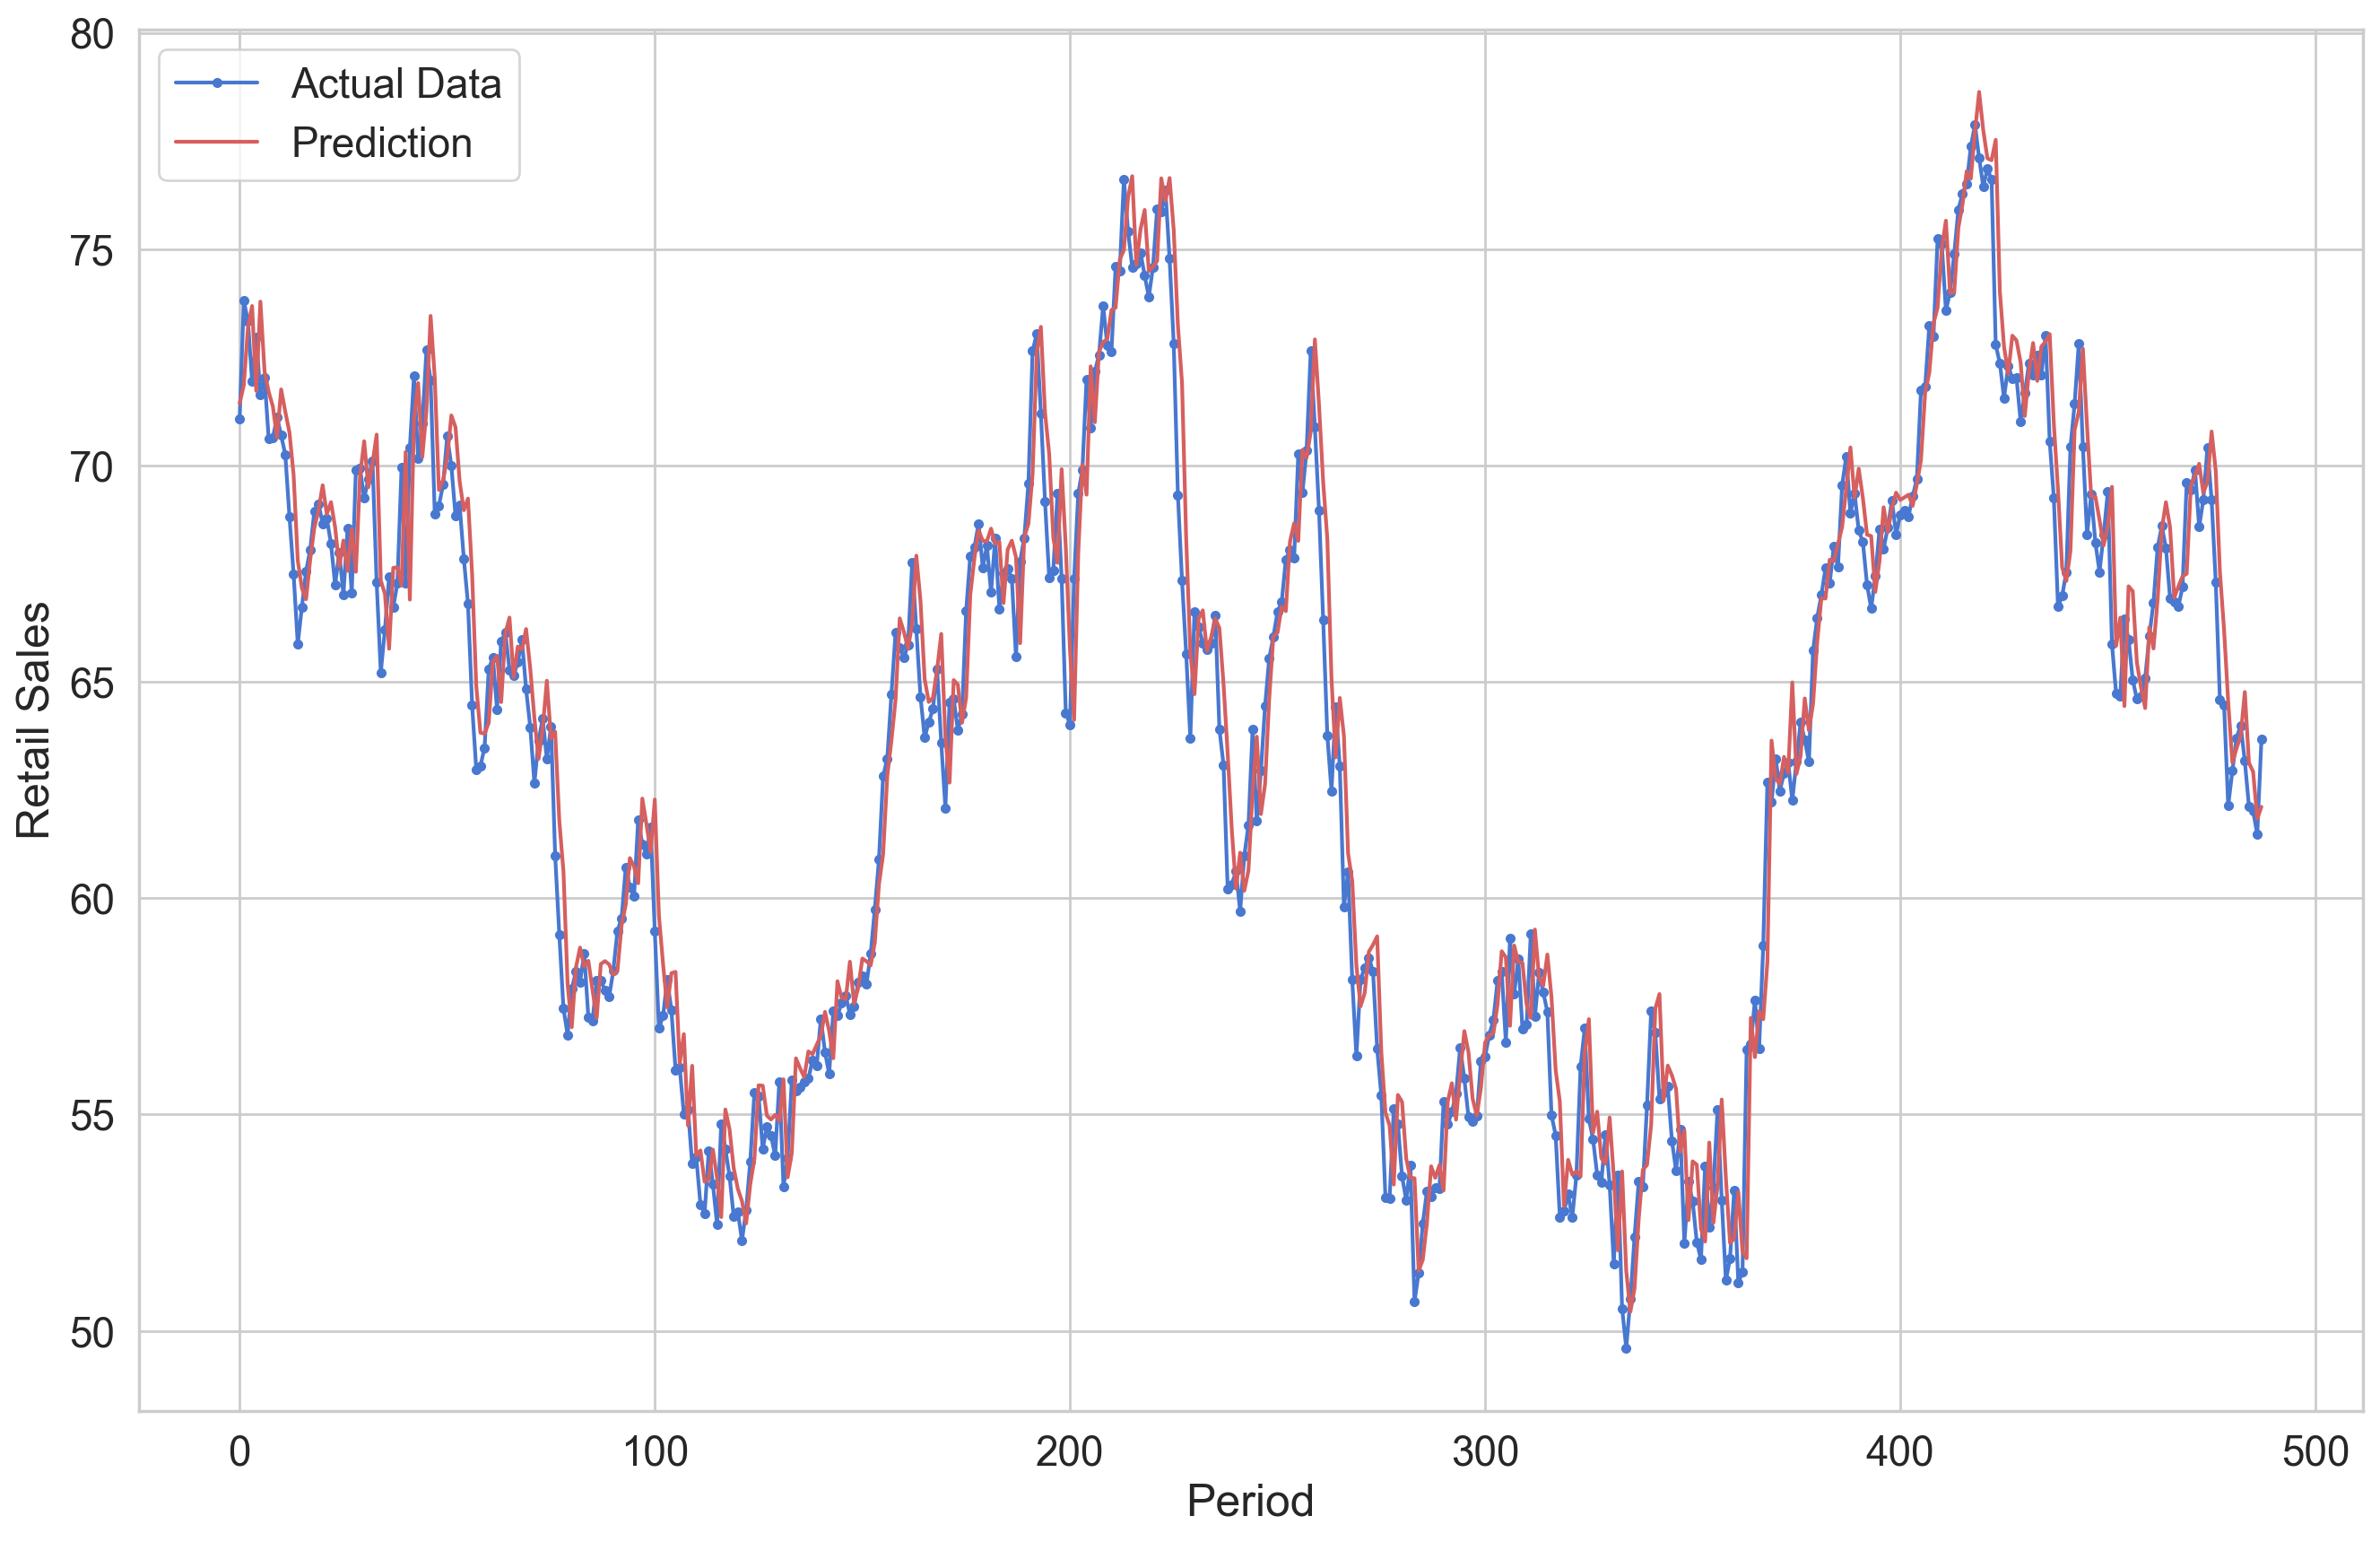

In [224]:

#this code essentially zooms in on only the values we predicted, allowing for easier comparison between
#predicted values and the true values
print(len(y_test)," ",len(y_pred))
plt.plot(y_test, marker='.', label="Actual Data")
plt.plot(y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.savefig("MLP.png")
plt.show();


This model tracks fairly well with the time serries, which we can see by how closely the red line is to the blue line. the red line, the predicted value, does tend to deviate slightly from the blue line in certain areas, but it generally tracks fairly closely with the red line.